In [1]:
#https://colab.research.google.com/github/ml6team/quick-tips/blob/main/nlp/2021_04_22_shap_for_huggingface_transformers/explainable_transformers_using_shap.ipynb#scrollTo=7XgsySD-u_rN

import shap
import transformers

from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)

import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

/lustre/isaac/scratch/ababjac/pyvenv/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/lustre/isaac/scratch/ababjac/pyvenv/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_min

In [2]:
import helpers

In [3]:
import shap
import copy
from lightgbm.sklearn import LGBMClassifier
from sklearn.datasets import load_breast_cancer

X,y = load_breast_cancer(return_X_y=True)
lgbm = LGBMClassifier()
lgbm.fit(X,y)

print(X.shape)

explainer = shap.TreeExplainer(lgbm)
shap_values1 = explainer(X)
shap_values2 = copy.deepcopy(shap_values1)
shap_values2.values = shap_values2.values[:,:,1]
shap_values2.base_values = shap_values2.base_values[:,1]

print(shap_values2.shape)
#shap.plots.beeswarm(shap_values2)

(569, 30)
(569, 30)


In [63]:
codontable = {
'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
}

In [68]:
codons = list(codontable.keys())

In [27]:
df = pd.read_csv('./data/cub.csv', index_col=0)

#df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234)

In [5]:
import helpers

shap_df = helpers.add_codons_to_df(df, 'Sequence')

In [6]:
lengths = [len(seq.split(' ')) for seq in shap_df['codons_cleaned']]
shap_df['lengths'] = lengths

In [7]:
shap_df = shap_df[shap_df['lengths'] < 100].sample(5)

In [8]:
tokenizer_name = "./tokenizers/codonBERT"
model_name = "./models/codonBERT-binary-large_1/checkpoint-127330"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, token_type_ids=False, padding=True, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name).cpu()

pipe_binary = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, padding='longest')

`return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


In [9]:
pipe = pipe_binary
texts = shap_df['codons_cleaned']

explainer = shap.Explainer(pipe)
shap_values_binary = explainer(texts)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  20%|████████████████████████▏                                                                                                | 1/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  60%|███████████████████████████████████████████████████████████████████▊                                             | 3/5 [03:45<01:44, 52.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 4/5 [05:37<01:17, 77.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:29<00:00, 90.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 6it [09:21, 112.32s/it]                                                                                                                             


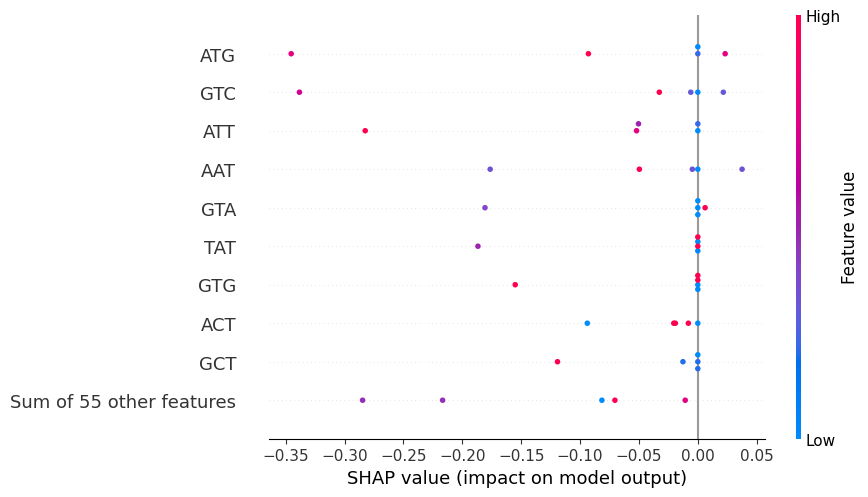

In [108]:
shap.plots.beeswarm(fix_shapley(shap_values_binary[:,:,1]))

In [77]:
svb2 = shap_values_binary[:,:,1]

In [90]:
svb2.values = new_vals1

In [98]:
new_exp = shap.Explanation(svb2.values, base_values=svb2.base_values, data=new_data1, feature_names=codons)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


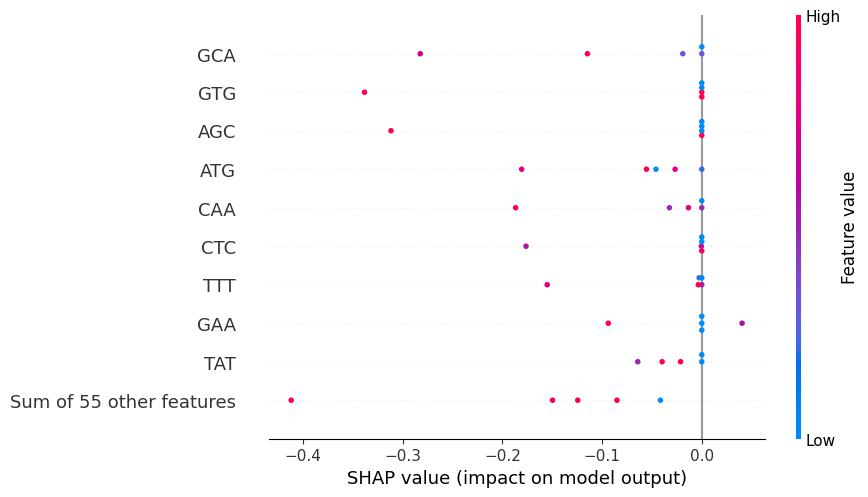

In [99]:
shap.plots.beeswarm(new_exp)

In [104]:

codontable = {
'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
}

codons = list(codontable.keys())
codon_dict = dict(zip(codons, list(range(len(codons))))) 

def fix_shapley(sbv2):

    new_vals1 = []
    new_data1 = []
    for data, vals in zip(svb2.data, svb2.values):
        l = [0]*len(codons)
        d = [0]*len(codons)
        for codon, val in zip(data, vals):
            codon = codon.replace(' ', '')
            l[codon_dict[codon]] += val
            d[codon_dict[codon]] += 1
    
        new_vals1.append(np.array(l))
        new_data1.append(np.array(d))
    
    new_vals1 = np.array(new_vals1)
    new_data1 = np.array(new_data1)
    
    new_exp = shap.Explanation(new_vals1, base_values=svb2.base_values, data=new_data1, feature_names=codons)
    
    return new_exp

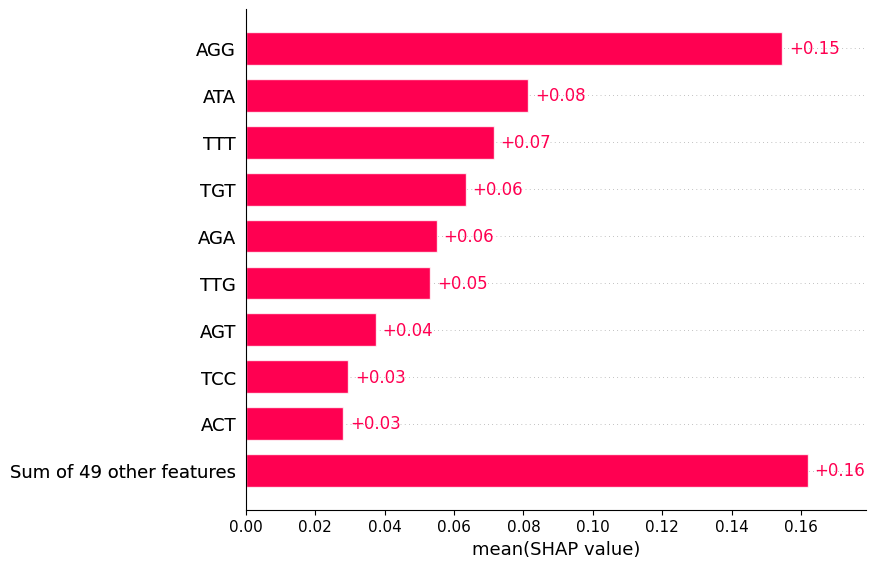

In [18]:
#shap.plots.bar(shap_values_binary[:,:,"LABEL_0"].mean(0))